# Question 1: Histogram of Training Documents

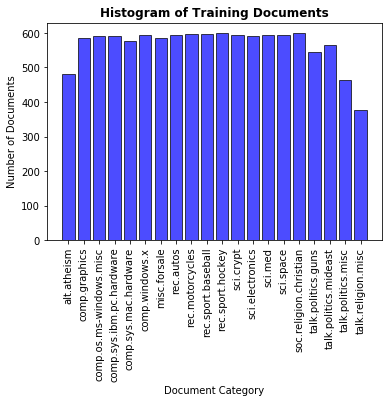

In [47]:
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt

newsgroups = fetch_20newsgroups(subset = 'train')
categories = list(newsgroups.target_names)
n_cats = len(categories)
n_docs = [0] * n_cats

for i in range(n_cats):
    cat = categories[i]
    newsgrooups_docs = fetch_20newsgroups(subset='train', categories=[cat])
    n_docs[i] = len(newsgrooups_docs.filenames)


plt.bar(categories, n_docs, facecolor='blue', alpha = 0.7, edgecolor='black', linewidth=1)
plt.xticks(categories, rotation=90)
# plt.tight_layout()
plt.xlabel('Document Category')
plt.ylabel('Number of Documents')
plt.title('Histogram of Training Documents', fontweight='bold')
plt.show()
# plt.savefig('hist.png')

# Question 2: Feature Extraction

In [2]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = 42)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = 42)

In [3]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from collections import defaultdict

# pos_tags: treebank to wordnet
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

wnl = WordNetLemmatizer()
    
def lemmatize(data):
    lemmatized = []
    for doc in data:
        tokens = word_tokenize(doc)
        words = [wnl.lemmatize(word, tag_map[tag[0]]) for word,tag in pos_tag(tokens) 
                 if wnl.lemmatize(word, tag_map[tag[0]]).isalpha()]
        sentence = ' '.join(words)
        lemmatized.append(sentence)
    return lemmatized

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

train_dataset_lemmatized = lemmatize(train_dataset.data)
test_dataset_lemmatized = lemmatize(test_dataset.data)

vectorizer = CountVectorizer(stop_words = 'english', min_df = 3)
X_train_counts = vectorizer.fit_transform(train_dataset_lemmatized)
X_test_counts = vectorizer.transform(test_dataset_lemmatized)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [5]:
print(X_train_counts.shape, X_test_counts.shape)

(4732, 12609) (3150, 12609)


# Question 3: Dimensionality Reduction

In [6]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

# Latent Semantic Indexing
lsi = TruncatedSVD(n_components=50, random_state=42)
X_train_LSI = lsi.fit_transform(X_train_tfidf)
X_test_LSI = lsi.transform(X_test_tfidf)

USigmaVt = lsi.inverse_transform(X_train_LSI)
LSI_frobenius = np.sum(np.array(X_train_tfidf - USigmaVt)**2)
print("Squared Frobenius Norm for LSI: " + str(LSI_frobenius))

Squared Frobenius Norm for LSI: 4120.154566659287


In [7]:
# Non-negativee Matrix Factorization
from sklearn.decomposition import NMF

nmf = NMF(n_components=50, random_state=42)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)

WH = np.dot(X_train_NMF, nmf.components_)
NMF_frobenius = np.sum(np.array(X_train_tfidf - WH)**2)
print("Squared Frobenius Norm for NMF: " + str(NMF_frobenius))

Squared Frobenius Norm for NMF: 4153.758243848824


# Question 4: Classification Algorithms SVM

In [8]:
# convert to binary classes
Y_train_binary = np.zeros(train_dataset.target.shape)
Y_test_binary = np.zeros(test_dataset.target.shape)

Y_train_binary[train_dataset.target > 3] = 1
Y_test_binary[test_dataset.target > 3] = 1

In [9]:
from sklearn.svm import SVC

svm_hard = SVC(C=1000, kernel='linear', random_state=42)
svm_soft = SVC(C=0.0001, kernel='linear', random_state=42)

svm_hard.fit(X_train_LSI, Y_train_binary)
svm_soft.fit(X_train_LSI, Y_train_binary)

Y_test_prob_hard = svm_hard.decision_function(X_test_LSI)
Y_test_label_hard = svm_hard.predict(X_test_LSI)
Y_test_prob_soft = svm_soft.decision_function(X_test_LSI)
Y_test_label_soft = svm_soft.predict(X_test_LSI)

In [10]:
from sklearn.metrics import roc_curve

fpr_hard, tpr_hard, _ = roc_curve(Y_test_binary, Y_test_prob_hard)
fpr_soft, tpr_soft, _ = roc_curve(Y_test_binary, Y_test_prob_soft)

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print('Hard Margin Linear SVMs:')
print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_hard))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_hard))
print('recall:', recall_score(Y_test_binary, Y_test_label_hard))
print('precision:', precision_score(Y_test_binary, Y_test_label_hard))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_hard))
print('\n')
print('Soft Margin Linear SVMs:')
print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_soft))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_soft))
print('recall:', recall_score(Y_test_binary, Y_test_label_soft))
print('precision:', precision_score(Y_test_binary, Y_test_label_soft))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_soft))

Hard Margin Linear SVMs:
confusion_matrix:
 [[1508   52]
 [  32 1558]]
accuracy: 0.9733333333333334
recall: 0.979874213836478
precision: 0.9677018633540373
f1_score: 0.97375


Soft Margin Linear SVMs:
confusion_matrix:
 [[   0 1560]
 [   0 1590]]
accuracy: 0.5047619047619047
recall: 1.0
precision: 0.5047619047619047
f1_score: 0.6708860759493671


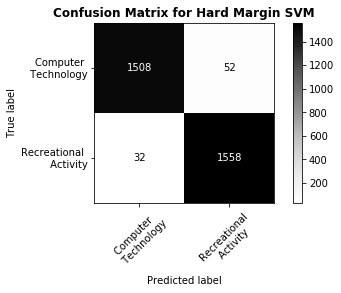

In [12]:
from sklearn.metrics import plot_confusion_matrix

class_names = ['Computer \n Technology', 'Recreational \n Activity']

plot_confusion_matrix(svm_hard, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Hard Margin SVM', fontweight='bold')
plt.show()
# plt.savefig('cm_hard.png')

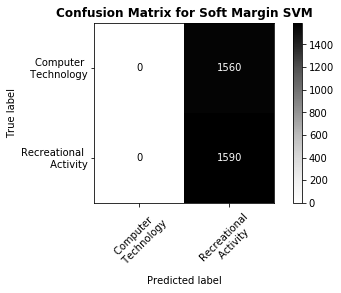

In [13]:
plot_confusion_matrix(svm_soft, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Soft Margin SVM', fontweight='bold')
plt.show()
# plt.savefig('cm_soft.png')

In [14]:
# Cross Validation
from sklearn.model_selection import GridSearchCV

svm_cv = GridSearchCV(estimator=SVC(kernel='linear', probability=True, random_state=42), 
                      param_grid={'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}, cv=5)

svm_cv.fit(X_train_LSI, Y_train_binary)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=True, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [15]:
import pandas as pd

pd.DataFrame(svm_cv.cv_results_)[['param_C','mean_test_score']]

,param_C,mean_test_score
0,0.001,0.504861
1,0.01,0.507396
2,0.1,0.964074
3,1,0.972104
4,10,0.975063
5,100,0.976330
6,1000,0.977597


In [16]:
svm_best = SVC(C=svm_cv.best_params_['C'], kernel='linear', random_state=42)
svm_best.fit(X_train_LSI, Y_train_binary)

Y_test_label_best = svm_best.predict(X_test_LSI)
Y_test_prob_best = svm_best.decision_function(X_test_LSI)

print('Best Linear SVMs:')
print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_best))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_best))
print('recall:', recall_score(Y_test_binary, Y_test_label_best))
print('precision:', precision_score(Y_test_binary, Y_test_label_best))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_best))

Best Linear SVMs:
confusion_matrix:
 [[1508   52]
 [  32 1558]]
accuracy: 0.9733333333333334
recall: 0.979874213836478
precision: 0.9677018633540373
f1_score: 0.97375


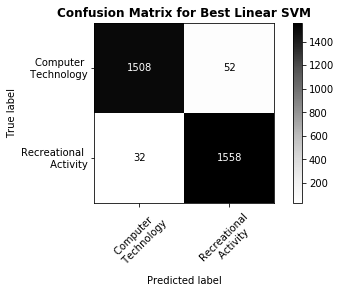

In [17]:
plot_confusion_matrix(svm_best, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Best Linear SVM', fontweight='bold')
plt.show()
# plt.savefig('cm_best.png')

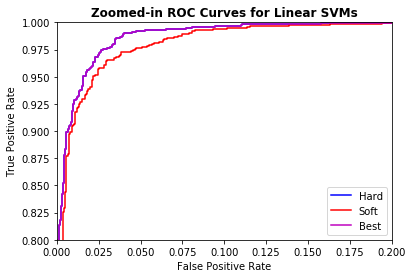

In [18]:
fpr_best, tpr_best, _ = roc_curve(Y_test_binary, Y_test_prob_best)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_hard, tpr_hard, label = 'Hard', color = 'b')
plt.plot(fpr_soft, tpr_soft, label = 'Soft', color = 'r')
plt.plot(fpr_best, tpr_best, label = 'Best', color = 'm')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.xlim(0,0.2)
plt.ylim(0.8,1)
plt.title('Zoomed-in ROC Curves for Linear SVMs', fontweight="bold")
plt.show()
# plt.savefig('ROC_SVMs_detail.png')

# Question 5: Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

# without regularization
logistic_raw = LogisticRegression(C=10**15, solver='newton-cg',  random_state=42)
logistic_raw.fit(X_train_LSI, Y_train_binary)

Y_test_label_logistic = logistic_raw.predict(X_test_LSI)
Y_test_prob_logistic = logistic_raw.decision_function(X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_logistic))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_logistic))
print('recall:', recall_score(Y_test_binary, Y_test_label_logistic))
print('precision:', precision_score(Y_test_binary, Y_test_label_logistic))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_logistic))

confusion_matrix:
 [[1508   52]
 [  25 1565]]
accuracy: 0.9755555555555555
recall: 0.9842767295597484
precision: 0.9678416821273964
f1_score: 0.9759900218272529


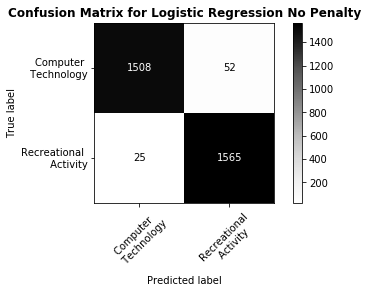

In [20]:
plot_confusion_matrix(logistic_raw, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Logistic Regression No Penalty', fontweight='bold')
plt.show()
# plt.savefig('cm_lr_no.png')

In [21]:
# best logistic regression with l1 penalty 
logistic_l1_cv = GridSearchCV(estimator=LogisticRegression(penalty='l1', solver='liblinear', random_state=42), 
                              param_grid={'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}, cv=5)
logistic_l1_cv.fit(X_train_LSI, Y_train_binary)

pd.DataFrame(logistic_l1_cv.cv_results_)[['param_C','mean_test_score']]

,param_C,mean_test_score
0,0.001,0.495139
1,0.01,0.936601
2,0.1,0.951184
3,1,0.970414
4,10,0.975273
5,100,0.978020
6,1000,0.978231


In [22]:
logistic_l1_best = LogisticRegression(penalty='l1', C=logistic_l1_cv.best_params_['C'], 
                                      solver='liblinear', random_state=42)
logistic_l1_best.fit(X_train_LSI, Y_train_binary)

Y_test_label_logisticl1 = logistic_l1_best.predict(X_test_LSI)
Y_test_prob_logisticl1 = logistic_l1_best.decision_function(X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_logisticl1))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_logisticl1))
print('recall:', recall_score(Y_test_binary, Y_test_label_logisticl1))
print('precision:', precision_score(Y_test_binary, Y_test_label_logisticl1))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_logisticl1))

confusion_matrix:
 [[1508   52]
 [  25 1565]]
accuracy: 0.9755555555555555
recall: 0.9842767295597484
precision: 0.9678416821273964
f1_score: 0.9759900218272529


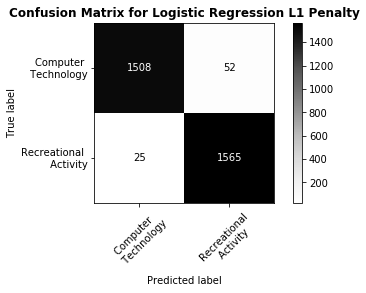

In [23]:
plot_confusion_matrix(logistic_l1_best, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Logistic Regression L1 Penalty', fontweight='bold')
plt.show()
# plt.savefig('cm_lr_l1.png')

In [24]:
# best logistic regression with l2 penalty 

logistic_l2_cv = GridSearchCV(estimator=LogisticRegression(penalty='l2', solver='newton-cg'), 
                              param_grid={'C':[10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3]}, cv=5)
logistic_l2_cv.fit(X_train_LSI, Y_train_binary)

pd.DataFrame(logistic_l2_cv.cv_results_)[['param_C','mean_test_score']]

,param_C,mean_test_score
0,0.001,0.542476
1,0.01,0.938293
2,0.1,0.963440
3,1,0.969357
4,10,0.974641
5,100,0.977598
6,1000,0.977809


In [25]:
logistic_l2_best = LogisticRegression(penalty='l2', C=logistic_l2_cv.best_params_['C'], 
                                      solver='newton-cg', random_state=42)
logistic_l2_best.fit(X_train_LSI, Y_train_binary)

Y_test_label_logisticl2 = logistic_l2_best.predict(X_test_LSI)
Y_test_prob_logisticl2 = logistic_l2_best.decision_function(X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_logisticl2))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_logisticl2))
print('recall:', recall_score(Y_test_binary, Y_test_label_logisticl2))
print('precision:', precision_score(Y_test_binary, Y_test_label_logisticl2))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_logisticl2))

confusion_matrix:
 [[1507   53]
 [  23 1567]]
accuracy: 0.9758730158730159
recall: 0.9855345911949686
precision: 0.967283950617284
f1_score: 0.9763239875389408


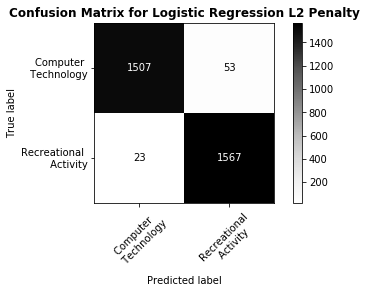

In [26]:
plot_confusion_matrix(logistic_l2_best, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for Logistic Regression L2 Penalty', fontweight='bold')
plt.show()
# plt.savefig('cm_lr_l2.png')

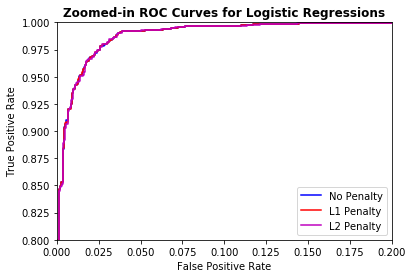

In [27]:
fpr_logistic, tpr_logistic, _ = roc_curve(Y_test_binary, Y_test_prob_logistic)
fpr_logisticl1, tpr_logisticl1, _ = roc_curve(Y_test_binary, Y_test_prob_logisticl1)
fpr_logisticl2, tpr_logisticl2, _ = roc_curve(Y_test_binary, Y_test_prob_logisticl2)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logistic, tpr_logistic, label = 'No Penalty', color = 'b')
plt.plot(fpr_logisticl1, tpr_logisticl1, label = 'L1 Penalty', color = 'r')
plt.plot(fpr_logisticl2, tpr_logisticl2, label = 'L2 Penalty', color = 'm')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoomed-in ROC Curves for Logistic Regressions', fontweight='bold')
plt.xlim(0,0.2)
plt.ylim(0.8,1)
plt.legend(loc='lower right')
plt.show()
# plt.savefig('ROC_LRs_detail.png')

# Question 6: Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB

gauss_nb = GaussianNB()
gauss_nb.fit(X_train_LSI, Y_train_binary)

Y_test_label_nb = gauss_nb.predict(X_test_LSI)
Y_test_prob_nb = gauss_nb.predict_proba(X_test_LSI)[:,1]


print('confusion_matrix:\n', confusion_matrix(Y_test_binary, Y_test_label_nb))
print('accuracy:', accuracy_score(Y_test_binary, Y_test_label_nb))
print('recall:', recall_score(Y_test_binary, Y_test_label_nb))
print('precision:', precision_score(Y_test_binary, Y_test_label_nb))
print('f1_score:', f1_score(Y_test_binary, Y_test_label_nb))

confusion_matrix:
 [[1107  453]
 [  37 1553]]
accuracy: 0.8444444444444444
recall: 0.9767295597484277
precision: 0.7741774675972084
f1_score: 0.8637374860956619


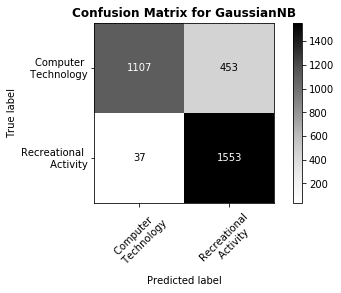

In [29]:
plot_confusion_matrix(gauss_nb, X_test_LSI, Y_test_binary, display_labels=class_names, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Confusion Matrix for GaussianNB', fontweight='bold')
plt.show()
# plt.savefig('cm_gaussnb.png')

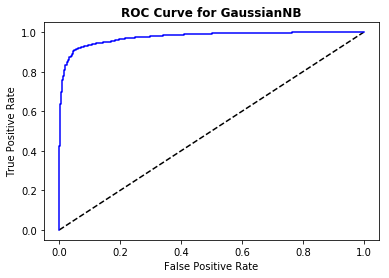

In [30]:
fpr_nb, tpr_nb, _ = roc_curve(Y_test_binary, Y_test_prob_nb)


plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nb, tpr_nb, label = 'Naive Bayes', color = 'b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GaussianNB', fontweight='bold')
plt.show()
# plt.savefig('ROC_NB.png')

# Question 7: Grid Search of Parameters

In [31]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vectorize', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD()),
    ('clf', SVC()),
])

parameters = [
    {
        'vectorize__min_df': [3,5],
        'reduce_dim': [TruncatedSVD(n_components=50, random_state=42), NMF(n_components=50, random_state=42)],
        'clf': [SVC(C=svm_cv.best_params_['C'], kernel='linear'), GaussianNB(),
               LogisticRegression(C=logistic_l1_best.C, penalty = 'l1', solver='liblinear', random_state=42),
               LogisticRegression(C=logistic_l2_best.C, penalty = 'l2', solver='newton-cg', random_state=42)]
    }
]

In [32]:
# With Headers and Footers
grid1 = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid = parameters, scoring='accuracy')
grid1.fit(train_dataset.data, Y_train_binary)
result_w_hf = pd.DataFrame(grid1.cv_results_)
result_w_hf['lemmatized'] = False
result_w_hf['with_headers_footers'] = True

grid2 = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid = parameters, scoring='accuracy')
grid2.fit(train_dataset_lemmatized, Y_train_binary)
result_lemm_w_hf = pd.DataFrame(grid2.cv_results_)
result_lemm_w_hf['lemmatized'] = True
result_lemm_w_hf['with_headers_footers'] = True

# Without Headers and Footers
train_dataset_wo_hf = fetch_20newsgroups(subset = 'train', categories = categories, 
                                         remove = ('headers','footers'), shuffle = True, random_state = None)

Y_train_binary_wo_hf = np.zeros(train_dataset_wo_hf.target.shape)
Y_train_binary_wo_hf[train_dataset_wo_hf.target > 3] = 1


grid3 = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid = parameters, scoring='accuracy')
grid3.fit(train_dataset_wo_hf.data, Y_train_binary_wo_hf)
result_wo_hf = pd.DataFrame(grid3.cv_results_)
result_wo_hf['lemmatized'] = False
result_wo_hf['with_headers_footers'] = False

grid4 = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid = parameters, scoring='accuracy')
grid4.fit(lemmatize(train_dataset_wo_hf.data), Y_train_binary_wo_hf)
result_lemm_wo_hf = pd.DataFrame(grid4.cv_results_)
result_lemm_wo_hf['lemmatized'] = True
result_lemm_wo_hf['with_headers_footers'] = False

In [33]:
results = pd.concat([result_w_hf, result_lemm_w_hf, result_wo_hf, result_lemm_wo_hf])
results = results[['mean_test_score', 'param_clf', 'param_reduce_dim','param_vectorize__min_df',
                   'lemmatized', 'with_headers_footers']].sort_values(by=['mean_test_score'], ascending=False)
results = results.reset_index(drop=True)

In [34]:
pd.set_option('display.max_colwidth', -1)

In [35]:
results.head()

,mean_test_score,param_clf,param_reduce_dim,param_vectorize__min_df,lemmatized,with_headers_footers
0,0.977388,"LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=42, solver='newton-cg', tol=0.0001, verbose=0,\n warm_start=False)","TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,\n tol=0.0)",5,True,True
1,0.977176,"LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='auto', n_jobs=None, penalty='l2',\n random_state=42, solver='newton-cg', tol=0.0001, verbose=0,\n warm_start=False)","TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,\n tol=0.0)",3,True,True
2,0.976965,"LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='auto', n_jobs=None, penalty='l1',\n random_state=42, solver='liblinear', tol=0.0001, verbose=0,\n warm_start=False)","TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,\n tol=0.0)",5,True,True
3,0.976331,"SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,\n decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',\n max_iter=-1, probability=False, random_state=None, shrinking=True,\n tol=0.001, verbose=False)","TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,\n tol=0.0)",5,True,True
4,0.976120,"SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,\n decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',\n max_iter=-1, probability=False, random_state=None, shrinking=True,\n tol=0.001, verbose=False)","TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5, random_state=42,\n tol=0.0)",3,True,True


# Question 8: Multiclass Classification

In [36]:
mclass_categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']

mclass_train_dataset = fetch_20newsgroups(subset = 'train', categories = mclass_categories, shuffle = True, random_state = 42)
mclass_test_dataset = fetch_20newsgroups(subset = 'test', categories = mclass_categories, shuffle = True, random_state = 42)

In [37]:
# lemmatization
mclass_train_dataset_lemmatized = lemmatize(mclass_train_dataset.data)
mclass_test_dataset_lemmatized = lemmatize(mclass_test_dataset.data)

# CountVectorizer
mclass_count = CountVectorizer(stop_words = 'english', min_df = 3)
mclass_X_train_count = mclass_count.fit_transform(mclass_train_dataset_lemmatized)
mclass_X_test_count = mclass_count.transform(mclass_test_dataset_lemmatized)

# TF-IDF
mclass_tfidf = TfidfTransformer()
mclass_X_train_tfidf = mclass_tfidf.fit_transform(mclass_X_train_count).toarray()
mclass_X_test_tfidf = mclass_tfidf.transform(mclass_X_test_count).toarray()

# LSI
mclass_lsi = TruncatedSVD(n_components = 50, random_state=42)
mclass_X_train_LSI = mclass_lsi.fit_transform(mclass_X_train_tfidf)
mclass_X_test_LSI = mclass_lsi.transform(mclass_X_test_tfidf)

# NMF
mclass_nmf = NMF(n_components=50, random_state=42)
mclass_X_train_NMF = mclass_nmf.fit_transform(mclass_X_train_tfidf)
mclass_X_test_NMF = mclass_nmf.transform(mclass_X_test_tfidf)

confusion_matrix:
 [[290  58  38   6]
 [ 52 284  44   5]
 [ 48  59 267  16]
 [  3   5   4 386]]
accuracy: 0.7840255591054313
recall: 0.7829807217190562
precision: 0.7821048775453165
f1_score: 0.7818877616189237


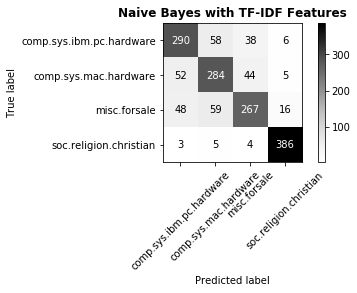

In [38]:
# Naive Bayes with TF-IDF
mclass_gauss_nb = GaussianNB()
mclass_gauss_nb.fit(mclass_X_train_tfidf, mclass_train_dataset.target)
mclass_Y_test_pred_nb = mclass_gauss_nb.predict(mclass_X_test_tfidf)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_nb))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_nb))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))

plot_confusion_matrix(mclass_gauss_nb, mclass_X_test_tfidf, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Naive Bayes with TF-IDF Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[213  32 143   4]
 [ 74 149 159   3]
 [ 52  22 312   4]
 [  0   0   9 389]]
accuracy: 0.6792332268370607
recall: 0.6769418171562823
precision: 0.7089028250180865
f1_score: 0.6701238762513697


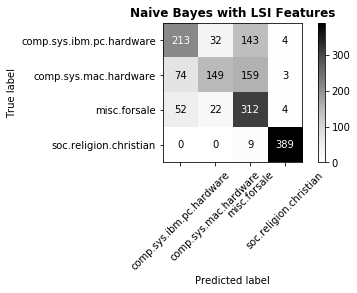

In [39]:
# Naive Bayes with LSI
mclass_gauss_nb = GaussianNB()
mclass_gauss_nb.fit(mclass_X_train_LSI, mclass_train_dataset.target)
mclass_Y_test_pred_nb = mclass_gauss_nb.predict(mclass_X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_nb))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_nb))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))

plot_confusion_matrix(mclass_gauss_nb, mclass_X_test_LSI, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Naive Bayes with LSI Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[288  40  58   6]
 [ 74 240  67   4]
 [ 53  25 292  20]
 [  3   0   3 392]]
accuracy: 0.7744408945686901
recall: 0.7729282681902927
precision: 0.7750071272643437
f1_score: 0.770962125080188


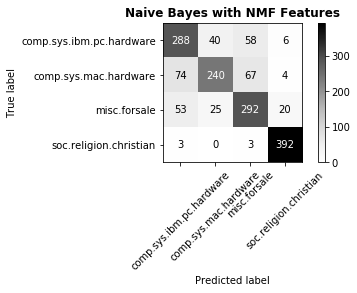

In [40]:
# Naive Bayes with NMF
mclass_gauss_nb = GaussianNB()
mclass_gauss_nb.fit(mclass_X_train_NMF, mclass_train_dataset.target)
mclass_Y_test_pred_nb = mclass_gauss_nb.predict(mclass_X_test_NMF)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_nb))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_nb))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_nb, average='macro'))

plot_confusion_matrix(mclass_gauss_nb, mclass_X_test_NMF, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('Naive Bayes with NMF Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[344  25  23   0]
 [ 37 332  15   1]
 [ 17  12 359   2]
 [  5   1   4 388]]
accuracy: 0.9092651757188498
recall: 0.9088189687794856
precision: 0.9096211308252671
f1_score: 0.9090285520944992


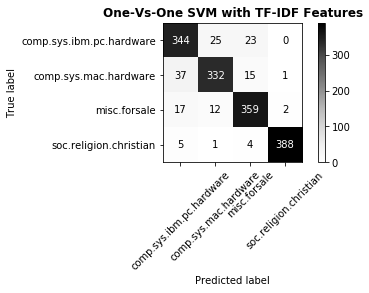

In [41]:
# One-Vs-One Linear SVM with TF-IDF
from sklearn.multiclass import OneVsOneClassifier

mclass_svm_ovo = OneVsOneClassifier(SVC(kernel='linear', random_state=42))
mclass_svm_ovo.fit(mclass_X_train_tfidf, mclass_train_dataset.target)
mclass_Y_test_pred_ovo = mclass_svm_ovo.predict(mclass_X_test_tfidf)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_ovo))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))

plot_confusion_matrix(mclass_svm_ovo, mclass_X_test_tfidf, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('One-Vs-One SVM with TF-IDF Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[349  26  17   0]
 [ 73 293  18   1]
 [ 29  12 346   3]
 [  8   1   6 383]]
accuracy: 0.876038338658147
recall: 0.8752090321140931
precision: 0.8816499086481204
f1_score: 0.8759767166354894


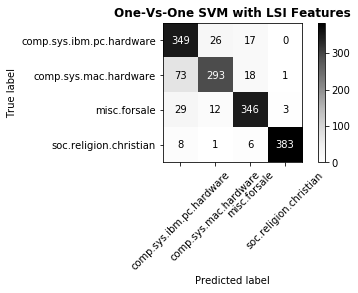

In [42]:
# One-Vs-One Linear SVM with LSI

mclass_svm_ovo = OneVsOneClassifier(SVC(kernel='linear', random_state=42))
mclass_svm_ovo.fit(mclass_X_train_LSI, mclass_train_dataset.target)
mclass_Y_test_pred_ovo = mclass_svm_ovo.predict(mclass_X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_ovo))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))

plot_confusion_matrix(mclass_svm_ovo, mclass_X_test_LSI, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('One-Vs-One SVM with LSI Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[352  35   5   0]
 [163 215   7   0]
 [ 90   9 288   3]
 [ 35   2   0 361]]
accuracy: 0.7769968051118211
recall: 0.7754743641139907
precision: 0.8313782577575681
f1_score: 0.7825235969834254


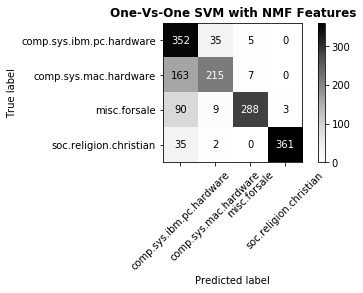

In [43]:
# One-Vs-One Linear SVM with NMF

mclass_svm_ovo = OneVsOneClassifier(SVC(kernel='linear', random_state=42))
mclass_svm_ovo.fit(mclass_X_train_NMF, mclass_train_dataset.target)
mclass_Y_test_pred_ovo = mclass_svm_ovo.predict(mclass_X_test_NMF)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_ovo))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_ovo, average='macro'))

plot_confusion_matrix(mclass_svm_ovo, mclass_X_test_NMF, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('One-Vs-One SVM with NMF Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[342  29  20   1]
 [ 31 338  14   2]
 [ 13  13 362   2]
 [  3   0   3 392]]
accuracy: 0.91629392971246
recall: 0.9158752022086551
precision: 0.9158311935225838
f1_score: 0.9158102864555878


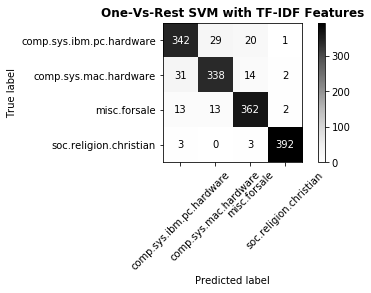

In [44]:
# One-Vs-Rest Linear SVM with TF-IDF
from sklearn.multiclass import OneVsRestClassifier

mclass_svm_ovr = OneVsRestClassifier(SVC(kernel='linear', random_state=42))
mclass_svm_ovr.fit(mclass_X_train_tfidf, mclass_train_dataset.target)
mclass_Y_test_pred_ovr = mclass_svm_ovr.predict(mclass_X_test_tfidf)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_ovr))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))

plot_confusion_matrix(mclass_svm_ovr, mclass_X_test_tfidf, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('One-Vs-Rest SVM with TF-IDF Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[325  42  23   2]
 [ 52 301  25   7]
 [ 20  12 350   8]
 [  2   0   3 393]]
accuracy: 0.8747603833865815
recall: 0.8739432244591971
precision: 0.8734445513184663
f1_score: 0.8732465425019968


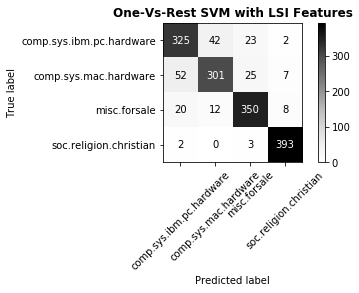

In [45]:
# One-Vs-Rest Linear SVM with LSI

mclass_svm_ovr = OneVsRestClassifier(SVC(kernel='linear', random_state=42))
mclass_svm_ovr.fit(mclass_X_train_LSI, mclass_train_dataset.target)
mclass_Y_test_pred_ovr = mclass_svm_ovr.predict(mclass_X_test_LSI)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_ovr))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))

plot_confusion_matrix(mclass_svm_ovr, mclass_X_test_LSI, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('One-Vs-Rest SVM with LSI Features', fontweight='bold')
plt.show()

confusion_matrix:
 [[304  48  24  16]
 [ 83 248  27  27]
 [ 28  12 330  20]
 [  2   2   1 393]]
accuracy: 0.8146964856230032
recall: 0.8133142700802427
precision: 0.8136833093459099
f1_score: 0.8101277923074562


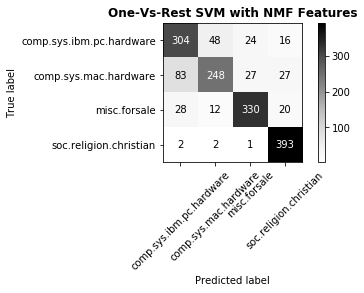

In [46]:
# One-Vs-Rest Linear SVM with NMF

mclass_svm_ovr = OneVsRestClassifier(SVC(kernel='linear', random_state=42))
mclass_svm_ovr.fit(mclass_X_train_NMF, mclass_train_dataset.target)
mclass_Y_test_pred_ovr = mclass_svm_ovr.predict(mclass_X_test_NMF)

print('confusion_matrix:\n', confusion_matrix(mclass_test_dataset.target, mclass_Y_test_pred_ovr))
print('accuracy:', accuracy_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr))
print('recall:', recall_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))
print('precision:', precision_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))
print('f1_score:', f1_score(mclass_test_dataset.target, mclass_Y_test_pred_ovr, average='macro'))

plot_confusion_matrix(mclass_svm_ovr, mclass_X_test_NMF, mclass_test_dataset.target, display_labels=mclass_categories, 
                             values_format='d', xticks_rotation=45, cmap=plt.cm.Greys)
plt.tight_layout()
plt.title('One-Vs-Rest SVM with NMF Features', fontweight='bold')
plt.show()